# Import Packages

In [54]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import pytz 
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import ast
import string
from wordcloud import WordCloud
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from googletrans import Translator
import pandas as pd
import numpy as np
import json
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re, string, unicodedata
import nltk
from nltk import word_tokenize, sent_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
nltk.corpus.stopwords.words('indonesian')
from nltk.tokenize import TweetTokenizer
import preprocessor as p

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\prime\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\prime\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Import Data

In [60]:
df = pd.read_excel('raw_sentiment.xlsx')
df.head()

,Unnamed: 0,content
0,0,Semoga g omicron ya Tuhan
1,1,"@dinagustavsson Ada delta,omicron ,cacar munyu..."
2,2,Ayo sukseskan vaksinasi Covid-19 dengan melaku...
3,3,Agar terhindar dr varian baru omicron BA.4 &am...
4,4,"Ambil baik nya, pas kenapa omicron, pertama bi..."


Removing Duplicate and Empty if any

In [61]:
df = df.drop_duplicates()
df = df.dropna(subset=['content'])
df = df.reset_index(drop=True)
len(df)

21617

# Extra Cleaning

In [62]:
df['content'].tail()

21612    Pengaruh nya apa pak? Jadi bagaimana mereka yg...
21613         Catat broo... @gunawanboydeep_ @afzhan_white
21614      Skenario untuk puasa dan idul fitri mulai dbuat
21615                   Langsung masuk kubur ajalah kau...
21616                                        Opung nggak??
Name: content, dtype: object

In [63]:
df['hashtag'] = df['content'].apply(lambda x: re.findall(r"#(\w+)", x))

for i,v in enumerate(df['content']):
    df.loc[i,'content'] = p.clean(v)

def preprocess_data(data):
    #Removes Numbers
    data = data.astype(str).str.replace('\d+', '')
    lower_text = data.str.lower()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    w_tokenizer =  TweetTokenizer()
 
    def lemmatize_text(text):
        return [(lemmatizer.lemmatize(w)) for w in w_tokenizer.tokenize((text))]
    
    def remove_punctuation(words):
        new_words = []
        for word in words:
            new_word = re.sub(r'[^\w\s]', '', (word))
            if new_word != '':
                new_words.append(new_word)
        return new_words
 
    words = lower_text.apply(lemmatize_text)
    words = words.apply(remove_punctuation)
    return pd.DataFrame(words)

pre_tweets = preprocess_data(df['content'])
df['content'] = pre_tweets
stop_words = set(stopwords.words('indonesian'))
df['content'] = df['content'].apply(lambda x: [item for item in x if item not in stop_words])
df['content'] = df['content'].str.join(" ")
from ekphrasis.classes.segmenter import Segmenter
# segmenter using the word statistics from Twitter
seg_tw = Segmenter(corpus="twitter")
a = []
for i in range(len(df)):
    if any(h in df['hashtag'][i] for h in a):
        listToStr1 = ' '.join([str(elem) for elem in df['hashtag'][i]])
        df.loc[i,'Segmented#'] = seg_tw.segment(listToStr1)

C:\Users\prime\AppData\Local\Temp/ipykernel_48008/3538242542.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  data = data.astype(str).str.replace('\d+', '')


Reading twitter - 1grams ...
Reading twitter - 2grams ...


In [64]:
df.head()

,Unnamed: 0,content,hashtag
0,0,semoga g omicron ya tuhan,[]
1,1,delta omicron cacar munyuk sampe hiv akibat va...,[]
2,2,ayo sukseskan vaksinasi covid vaksin dosis len...,"[TetapProkesLengkapiVaksin, IndonesiaSemakinHe..."
3,3,terhindar dr varian omicron ba ba masyarakat d...,"[TetapProkesLengkapiVaksin, IndonesiaSemakinHe..."
4,4,ambil nya pa omicron account tik tok haha tik ...,[gaptekdotcom]


# Word Processing

## Create word dictionary

In [67]:
word_dict = {}
for i in range(0,len(df['content'])):
    sentence = df['content'][i]
    word_token = word_tokenize(sentence)
    for j in word_token:
        if j not in word_dict:
            word_dict[j] = 1
        else:
            word_dict[j] += 1

In [68]:
len(word_dict)

29978

## Import Lexicon data

import lexicon, and remove negation words from lexicon, the lexicon is a combination from several sources below, that combined together, and include swear words which has the most negative score

sources : <br>
https://github.com/louisowen6/NLP_bahasa_resources <br>
https://github.com/abhimantramb/elang/blob/master/word2vec/utils/swear-words.txt <br>
https://github.com/fajri91/InSet <br>
https://github.com/agusmakmun/SentiStrengthID/blob/master/id_dict/sentimentword.txt 

In [69]:
negasi = ['bukan','tidak','ga','gk']
lexicon = pd.read_csv('lexicon/modified_full_lexicon.csv')
lexicon = lexicon.drop(lexicon[(lexicon['word'] == 'bukan')
                               |(lexicon['word'] == 'tidak')
                               |(lexicon['word'] == 'ga')
                               |(lexicon['word'] == 'gk')
                               |(lexicon['word'] == 'g')].index,axis=0)
lexicon = lexicon.reset_index(drop=True)

In [70]:
len(lexicon)

10248

In [71]:
lexicon.head()

,word,weight,number_of_words
0,hai,3,1
1,merekam,2,1
2,ekstensif,3,1
3,paripurna,1,1
4,detail,2,1
5,pernik,3,1
6,belas,2,1
7,welas,4,1
8,kabung,1,1
9,rahayu,4,1


In [72]:
lexicon_word = lexicon['word'].to_list()
lexicon_num_words = lexicon['number_of_words']

In [73]:
len(lexicon_word)

10248

Checking if there is words in dictionary that does not included in the lexicon

In [74]:
ns_words = []
factory = StemmerFactory()
stemmer = factory.create_stemmer()
for word in word_dict.keys():
    if word not in lexicon_word:
        kata_dasar = stemmer.stem(word)
        if kata_dasar not in lexicon_word:
            ns_words.append(word)
len(ns_words)

24262

Let's take a look what kind of words they are, lets start with some words that have many occurences as this most likely not  a type case

In [75]:
len({k:v for (k,v) in word_dict.items() if ((k in ns_words)&(v>3)) })

4117

In [76]:
ns_words_list = {k:v for (k,v) in word_dict.items() if ((k in ns_words)&(v>3))}

It turns out that the words that is not included in lexicon, are the one that not have signifance sentiment

In [77]:
sort_orders = sorted(ns_words_list.items(), key=lambda x: x[1], reverse=True)
sort_orders=sort_orders[0:20]
for i in sort_orders:
    print(i[0], i[1])

omicron 21241
yg 3618
covid 3084
ga 2065
delta 1588
udah 1462
ba 1258
vaksin 1251
virus 1250
gejala 1207
gak 1112
ni 1076
gue 1000
kalo 977
sih 924
nya 921
tp 881
orang 828
booster 819
bgt 817


In [33]:
word_to_plot = df['clean_text'].copy()

In [34]:
word_to_plot_1 = word_to_plot.apply(lambda x: del_word(x,negasi))

creating word cloud to see what kind of words that appear often in the tweets related to the pandemic

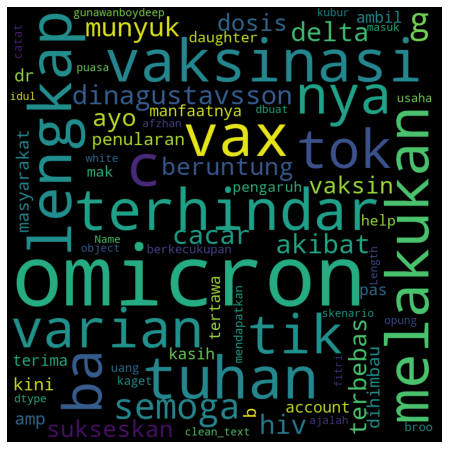

In [35]:
wordcloud = WordCloud(width = 800, height = 800, background_color = 'black', max_words = 1000
                      , min_font_size = 20).generate(str(word_to_plot_1))
#plot the word cloud
fig = plt.figure(figsize = (8,8), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## sentiment

In [36]:
lexicon['number_of_words'].value_counts()

1    9536
2     686
3      24
4       2
Name: number_of_words, dtype: int64

calculating the sentiment of words by mathing them to the lexicon while also creating the bag of words matrix

In [79]:
sencol =[]
senrow =np.array([])
nsen = 0
factory = StemmerFactory()
stemmer = factory.create_stemmer()
sentiment_list = []
# function to write the word's sentiment if it is founded
def found_word(ind,words,word,sen,sencol,sentiment,add):
    # if it is already included in the bag of words matrix, then just increase the value
    if word in sencol:
        sen[sencol.index(word)] += 1
    else:
    #if not, than add new word
        sencol.append(word)
        sen.append(1)
        add += 1
    #if there is a negation word before it, the sentiment would be the negation of it's sentiment
    if (words[ind-1] in negasi):
        sentiment += -lexicon['weight'][lexicon_word.index(word)]
    else:
        sentiment += lexicon['weight'][lexicon_word.index(word)]
    
    return sen,sencol,sentiment,add
            
# checking every words, if they are appear in the lexicon, and then calculate their sentiment if they do
for i in range(len(df)):
    nsen = senrow.shape[0]
    words = word_tokenize(df['content'][i])
    sentiment = 0 
    add = 0
    prev = [0 for ii in range(len(words))]
    n_words = len(words)
    if len(sencol)>0:
        sen =[0 for j in range(len(sencol))]
    else:
        sen =[]
    
    for word in words:
        ind = words.index(word)
        # check whether they are included in the lexicon
        if word in lexicon_word :
            sen,sencol,sentiment,add= found_word(ind,words,word,sen,sencol,sentiment,add)
        else:
        # if not, then check the root word
            kata_dasar = stemmer.stem(word)
            if kata_dasar in lexicon_word:
                sen,sencol,sentiment,add= found_word(ind,words,kata_dasar,sen,sencol,sentiment,add)
        # if still negative, try to match the combination of words with the adjacent words
            elif(n_words>1):
                if ind-1>-1:
                    back_1    = words[ind-1]+' '+word
                    if (back_1 in lexicon_word):
                        sen,sencol,sentiment,add= found_word(ind,words,back_1,sen,sencol,sentiment,add)
                    elif(ind-2>-1):
                        back_2    = words[ind-2]+' '+back_1
                        if back_2 in lexicon_word:
                            sen,sencol,sentiment,add= found_word(ind,words,back_2,sen,sencol,sentiment,add)
    # if there is new word founded, then expand the matrix
    if add>0:  
        if i>0:
            if (nsen==0):
                senrow = np.zeros([i,add],dtype=int)
            elif(i!=nsen):
                padding_h = np.zeros([nsen,add],dtype=int)
                senrow = np.hstack((senrow,padding_h))
                padding_v = np.zeros([(i-nsen),senrow.shape[1]],dtype=int)
                senrow = np.vstack((senrow,padding_v))
            else:
                padding =np.zeros([nsen,add],dtype=int)
                senrow = np.hstack((senrow,padding))
            senrow = np.vstack((senrow,sen))
        if i==0:
            senrow = np.array(sen).reshape(1,len(sen))
    # if there isn't then just update the old matrix
    elif(nsen>0):
        senrow = np.vstack((senrow,sen))
        
    sentiment_list.append(sentiment)

In [80]:
len(sentiment_list)

21617

In [81]:
print(senrow.shape[0])

21617


constructing the data frame that contain bag of words and the sentiments that have been calculated before

In [82]:
sencol.append('sentiment')
sentiment_array = np.array(sentiment_list).reshape(senrow.shape[0],1)
sentiment_data = np.hstack((senrow,sentiment_array))
df_sen = pd.DataFrame(sentiment_data,columns = sencol)

In [83]:
df_sen.head(10)

,moga,ya,tuhan,akibat,beruntung,bebas,ayo,sukses,lengkap,terhindar,...,menghukum,marilah,musyawarah,bait,menjerit,bajak,comel,berkecukupan,peler,sentiment
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
1,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,2
3,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,-3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-5
5,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-11
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-5
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-8
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


lets see if the sentiment is correct by looking at the original text

In [84]:
cek_df = pd.DataFrame([])
cek_df['text'] = df['content'].copy()
cek_df['sentiment']  = df_sen['sentiment'].copy()

In [85]:
cek_df

,text,sentiment
0,semoga g omicron ya tuhan,8
1,delta omicron cacar munyuk sampe hiv akibat va...,1
2,ayo sukseskan vaksinasi covid vaksin dosis len...,2
3,terhindar dr varian omicron ba ba masyarakat d...,-3
4,ambil nya pa omicron account tik tok haha tik ...,-5
...,...,...
21612,pengaruh nya yg berkecukupan hidup uang kaget ...,16
21613,catat broo,0
21614,skenario puasa idul fitri dbuat,-2
21615,langsung masuk kubur ajalah kau,1


In [88]:
cek_df.to_csv('omicron_sentiment.csv')
cek_df.to_excel('omicron_sentiment.xlsx')

# EDA

Text(0.5, 0, 'sentiment')

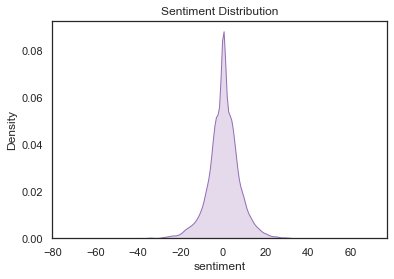

In [45]:
sns.set(style="white", palette="muted", color_codes=True)
sns.kdeplot(df_sen['sentiment'],color='m',shade=True)
plt.title('Sentiment Distribution')
plt.xlabel('sentiment')

<AxesSubplot:xlabel='sentiment'>

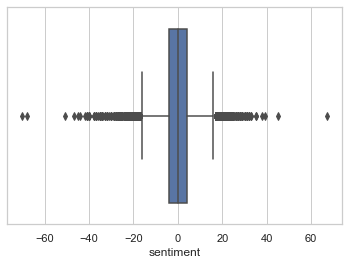

In [46]:
sns.set(style="whitegrid") 
sns.boxplot(x=df_sen['sentiment'])

It look like the sentiments are equally distributed between positive and negative, to be sure, lets take a look at the mean

In [47]:
df_sen.describe()

,moga,tuhan,akibat,beruntung,bebas,ayo,sukses,lengkap,terhindar,tular,...,marilah,pembesar,sepihak,bait,menjerit,bajak,comel,berkecukupan,peler,sentiment
count,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,...,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000,21611.000000
mean,0.025219,0.004072,0.006617,0.000555,0.005738,0.006247,0.001296,0.004674,0.003054,0.010226,...,0.000093,0.000046,0.000046,0.000046,0.000093,0.000231,0.000231,0.000416,0.000740,0.145620
std,0.168733,0.069918,0.083329,0.023558,0.085314,0.081675,0.035972,0.070211,0.055180,0.101525,...,0.013605,0.006802,0.006802,0.006802,0.009620,0.015209,0.015209,0.020403,0.038474,7.485104
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-70.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
max,4.000000,4.000000,2.000000,1.000000,4.000000,2.000000,1.000000,2.000000,1.000000,2.000000,...,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,67.000000


now lets take a look at the most occured words among the set of words that is included in lexicon

In [48]:
top15_word = df_sen.drop(['sentiment'],axis=1).sum().sort_values(ascending=False)[0:15]

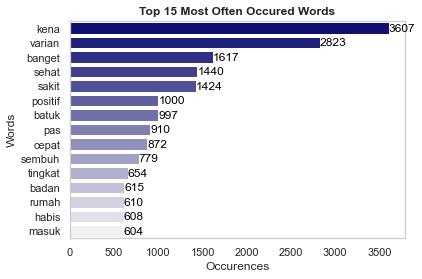

In [49]:
#pal =sns.dark_palette("purple", input="xkcd",n_colors=15)
pal =sns.light_palette("navy", reverse=True,n_colors=15)
g = sns.barplot(y = top15_word.index , x = top15_word,palette=pal)
g.grid(False)
plt.xlabel('Occurences')
plt.ylabel('Words')
plt.title("Top 15 Most Often Occured Words",fontweight='bold') 
for i in range(15):
    g.text(top15_word[i],i+0.22, top15_word[i],color='black')
plt.show()